# Sprint 06

Importamos librerías y leemos el csv.

In [59]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr, ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

data = pd.read_csv('bank_dataset.csv')

Transformamos los valores nulos con la media en el caso de columnas numéricas y con la moda en caso de columnas categóricas

In [60]:
# Preguntar
print("Tenemos valores nulos?")
print(data.isna().sum())

# Solucionar
for column in data.columns:
    if data[column].dtype in ['float64', 'int64']:  #columna numérica
        media = data[column].mean()  #media
        data[column] = data[column].fillna(media)  #reemplazar
    else:  #categórica
        moda = data[column].mode().iloc[0]  #moda
        data[column] = data[column].fillna(moda)  #reemplazar

# Confirmar
print("\nTenemos valores nulos?")
print(data.isna().sum())

Tenemos valores nulos?
age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Tenemos valores nulos?
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


## Análisis exploratorio EDA

In [44]:
# Primeras filas
print("Primeras filas")
print(data.head())
# Info
print("Info")
print(data.info())
# Resumen estadístico
print("Resumen estadístico")
print(data.describe())
print("Valores únicos por columna")
print(data.nunique())

Primeras filas
    age         job  marital  education default  balance housing loan  \
0  59.0      admin.  married  secondary      no     2343     yes   no   
1  56.0      admin.  married  secondary      no       45      no   no   
2  41.0  technician  married  secondary      no     1270     yes   no   
3  55.0    services  married  secondary      no     2476     yes   no   
4  54.0      admin.  married   tertiary      no      184      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes  
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 111

Eliminamos la variable 'pdays', ya que al menos el 50% de los valores es '-1', que podría considerarse como un valor nulo.

Calculamos la mediana y la moda para tener más información

In [45]:
print("\nMEDIAN FOR EACH COLUMN:")
print(data.median(numeric_only=True))  # Solo para columnas numéricas

print("\nMODE FOR EACH COLUMN:")
print(data.mode().iloc[0])


MEDIAN FOR EACH COLUMN:
age          39.0
balance     550.0
day          15.0
duration    255.0
campaign      2.0
pdays        -1.0
previous      0.0
dtype: float64

MODE FOR EACH COLUMN:
age                31.0
job          management
marital         married
education     secondary
default              no
balance               0
housing              no
loan                 no
contact        cellular
day                  20
month               may
duration             97
campaign              1
pdays                -1
previous              0
poutcome        unknown
deposit              no
Name: 0, dtype: object


Para obtener más información, también calculamos la desviación estándar

In [46]:
print("\nSTANDARD DEVIATION FOR EACH COLUMN:")
print(data.std(numeric_only=True))  # Solo para columnas numéricas


STANDARD DEVIATION FOR EACH COLUMN:
age           11.909596
balance     3225.413326
day            8.420740
duration     347.128386
campaign       2.722077
pdays        108.758282
previous       2.292007
dtype: float64


Distribución de job:
job
management       0.229887
blue-collar      0.174162
technician       0.163322
admin.           0.119513
services         0.082691
retired          0.069701
self-employed    0.036284
student          0.032252
unemployed       0.031984
entrepreneur     0.029385
housemaid        0.024548
unknown          0.006271
Name: proportion, dtype: float64




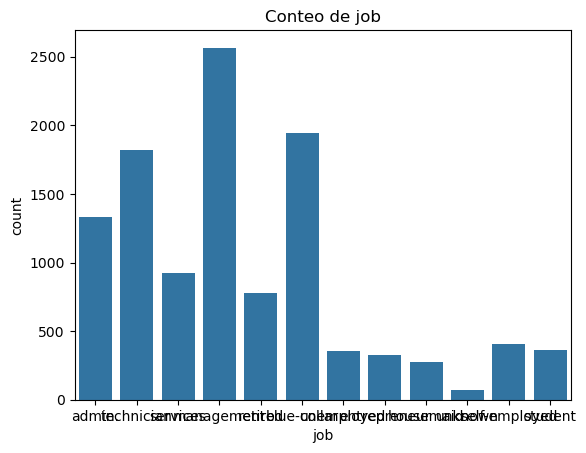

Distribución de marital:
marital
married     0.569253
single      0.315087
divorced    0.115660
Name: proportion, dtype: float64




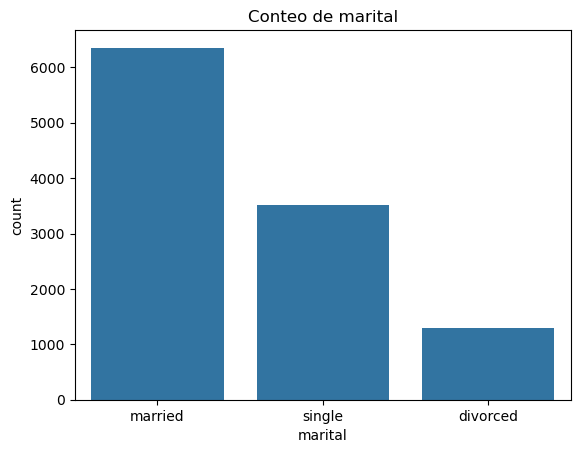

Distribución de education:
education
secondary    0.491041
tertiary     0.330138
primary      0.134385
unknown      0.044436
Name: proportion, dtype: float64




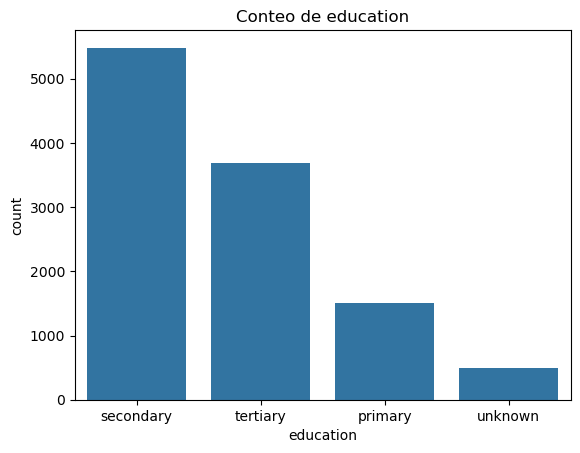

Distribución de default:
default
no     0.984949
yes    0.015051
Name: proportion, dtype: float64




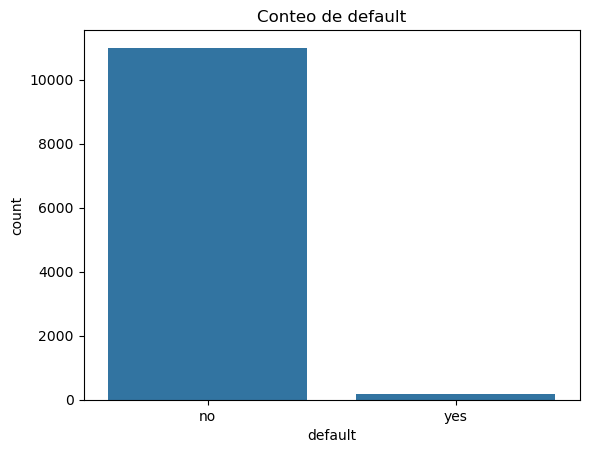

Distribución de housing:
housing
no     0.526877
yes    0.473123
Name: proportion, dtype: float64




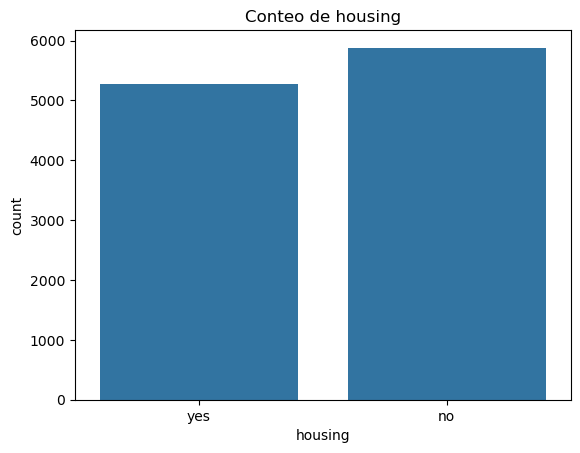

Distribución de loan:
loan
no     0.869199
yes    0.130801
Name: proportion, dtype: float64




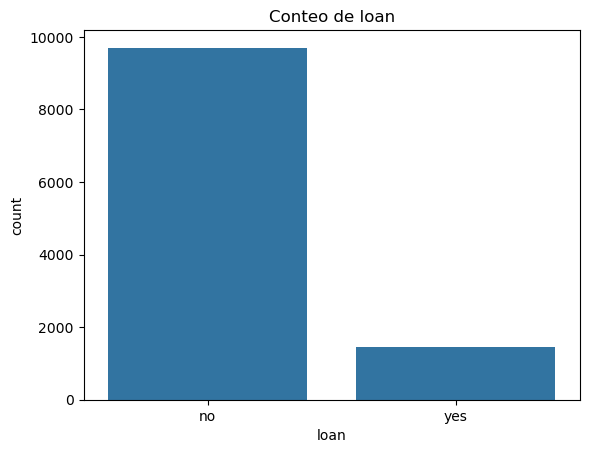

Distribución de contact:
contact
cellular     0.720480
unknown      0.210177
telephone    0.069342
Name: proportion, dtype: float64




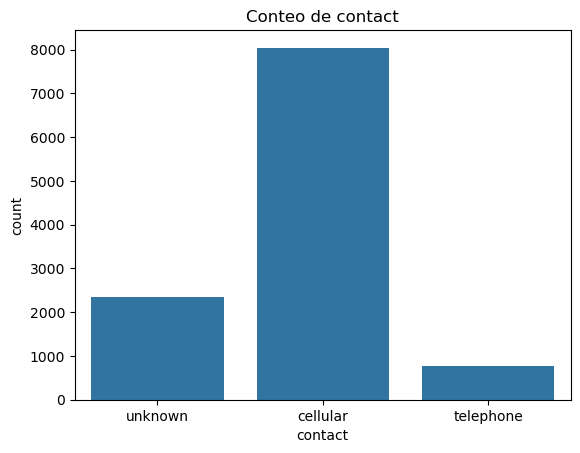

Distribución de month:
month
may    0.253001
aug    0.136087
jul    0.135639
jun    0.109479
nov    0.084483
apr    0.082691
feb    0.069522
oct    0.035119
jan    0.030819
sep    0.028579
mar    0.024727
dec    0.009855
Name: proportion, dtype: float64




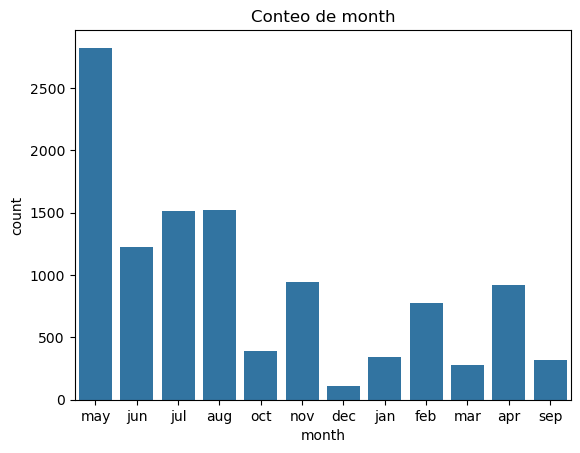

Distribución de poutcome:
poutcome
unknown    0.745924
failure    0.110016
success    0.095951
other      0.048110
Name: proportion, dtype: float64




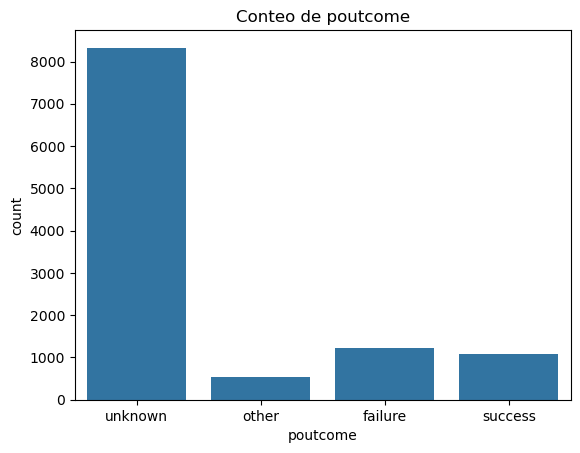

Distribución de deposit:
deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64




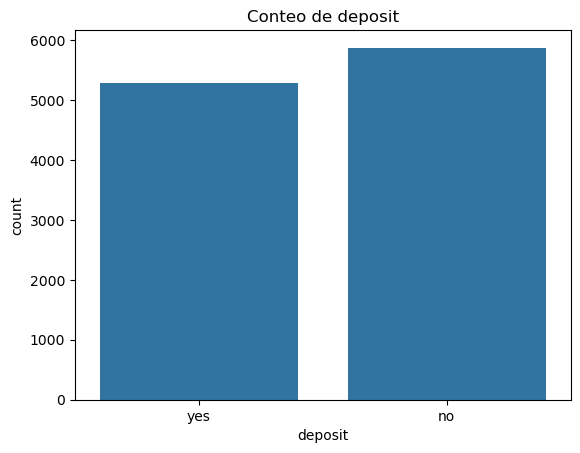

In [47]:
# Conteo de valores únicos por variable categórica
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"Distribución de {col}:")
    print(data[col].value_counts(normalize=True))
    print("\n")

    # Gráfico de barras
    sns.countplot(x=col, data=data)
    plt.title(f"Conteo de {col}")
    plt.show()

A continuación, realizaremos un análisis de la relación entre características y variable objetivo.
1. Variables numéricas:
- Hacemos un boxplot para ver la relación con target.
- Hacemos un test t de Welch para mirar diferencia de medias.
- Hacemos una correlación biserial puntual para cuantificar la relación entre características y variable objetivo.
2. Variables categóricas:
- Hacemos un gráfico de barras para ver la relación con target.
- Hacemos un test Chi-cuadrado para mirar independencia.
- Calculamos Phi para cuantificar la relación entre características y variable objetivo.


RELACIÓN ENTRE VARIABLES NUMÉRICAS Y VARIABLE OBJETIVO:


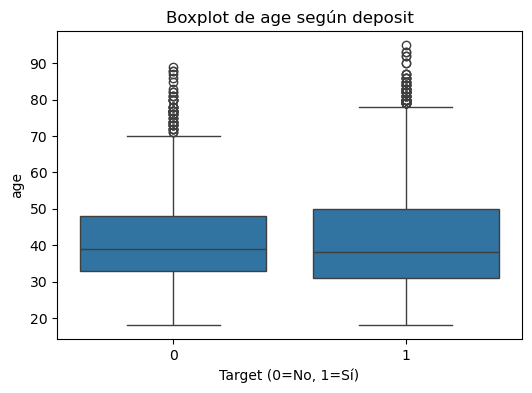

age: t-stat = 3.61, p-valor = 0.0003, Correlación Biserial = 0.0346


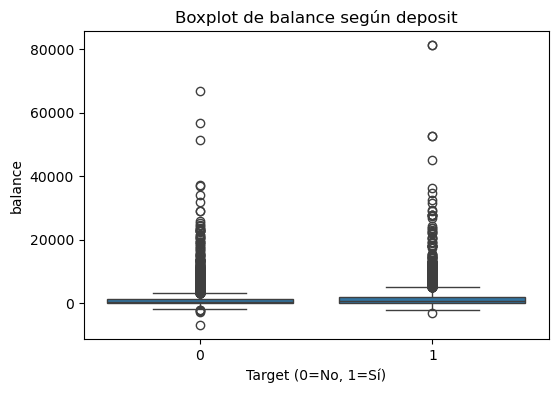

balance: t-stat = 8.52, p-valor = 0.0000, Correlación Biserial = 0.0811


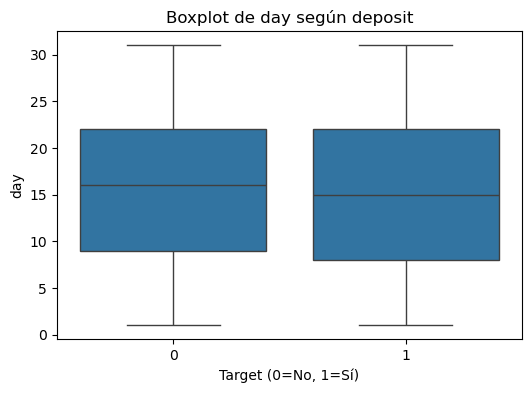

day: t-stat = -5.95, p-valor = 0.0000, Correlación Biserial = -0.0563


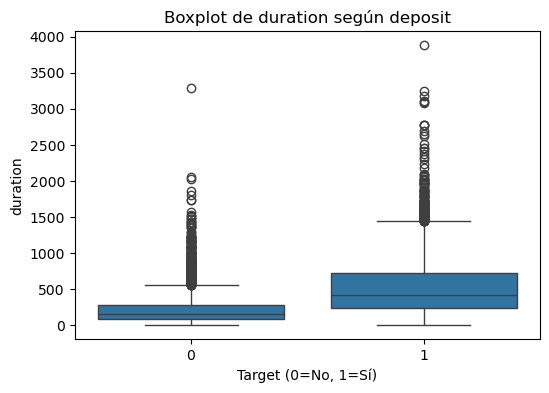

duration: t-stat = 51.97, p-valor = 0.0000, Correlación Biserial = 0.4519


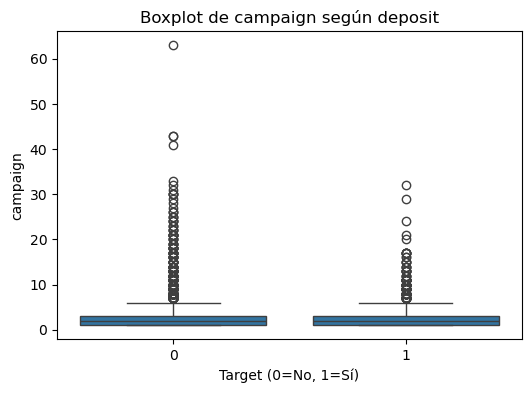

campaign: t-stat = -13.99, p-valor = 0.0000, Correlación Biserial = -0.1281


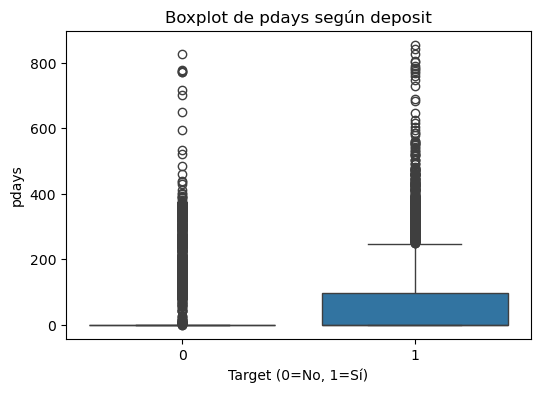

pdays: t-stat = 16.03, p-valor = 0.0000, Correlación Biserial = 0.1516


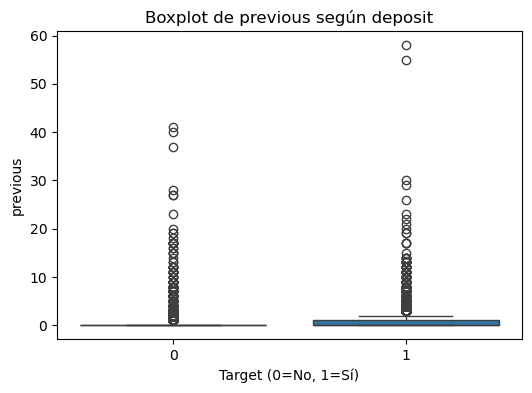

previous: t-stat = 14.73, p-valor = 0.0000, Correlación Biserial = 0.1399

RELACIÓN ENTRE VARIABLES CATEGÓRICAS Y LA VARIABLE OBJETIVO:
job: Chi² = 378.08, p-valor = 0.0000, Phi = 0.1840


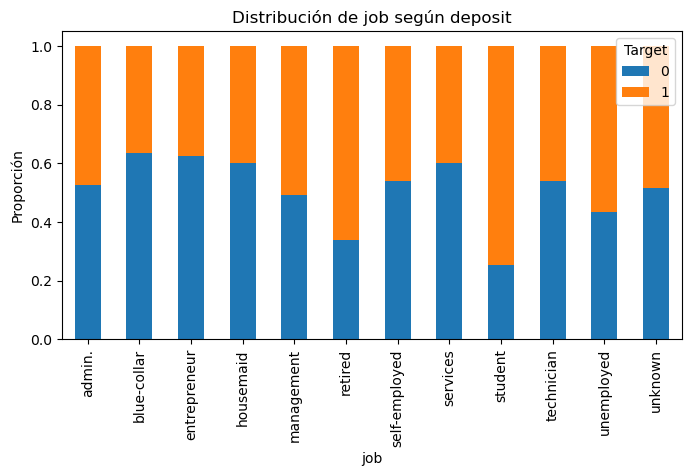

marital: Chi² = 108.73, p-valor = 0.0000, Phi = 0.0987


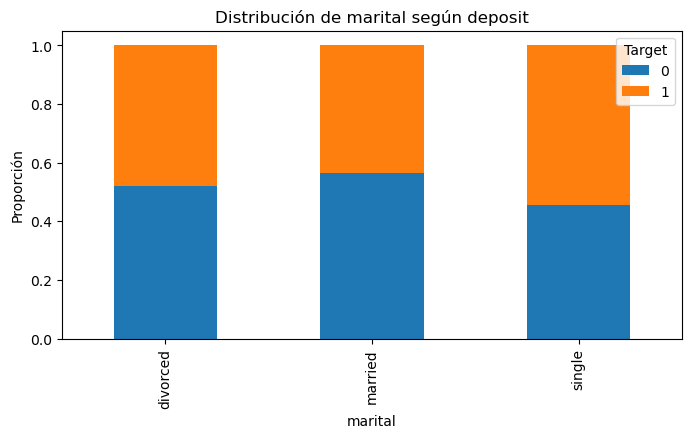

education: Chi² = 122.98, p-valor = 0.0000, Phi = 0.1050


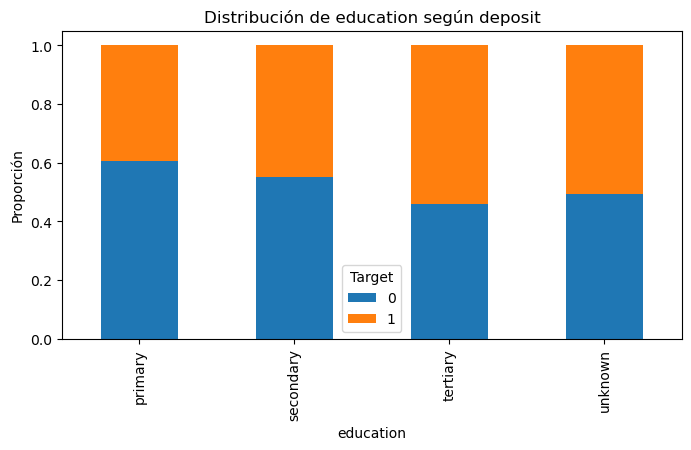

default: Chi² = 17.81, p-valor = 0.0000, Phi = 0.0399


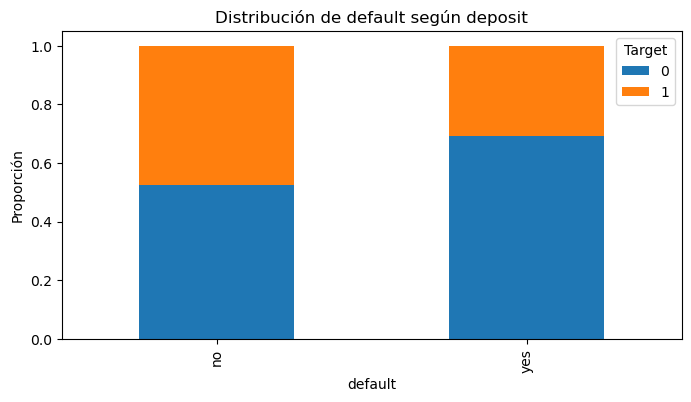

housing: Chi² = 463.19, p-valor = 0.0000, Phi = 0.2037


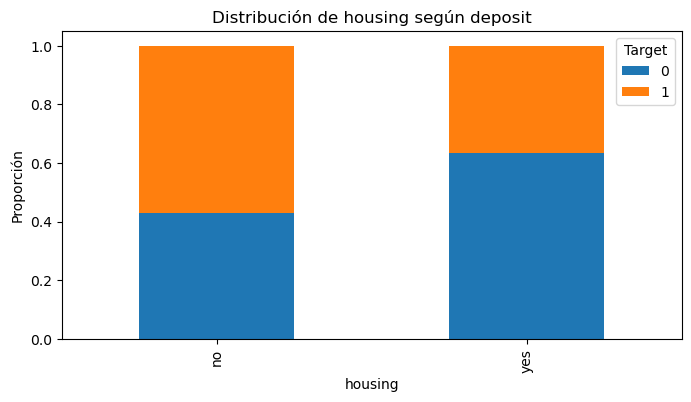

loan: Chi² = 135.83, p-valor = 0.0000, Phi = 0.1103


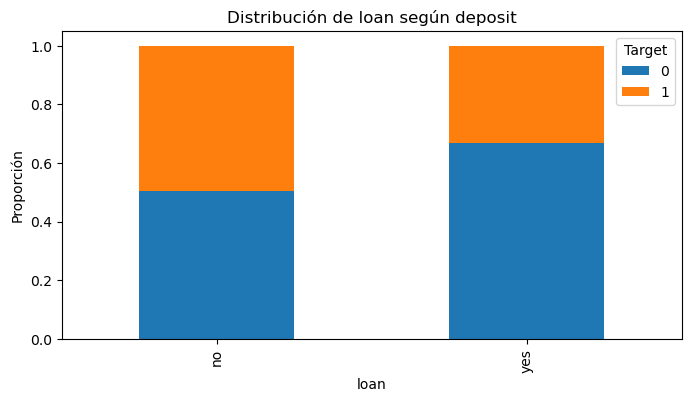

contact: Chi² = 736.69, p-valor = 0.0000, Phi = 0.2569


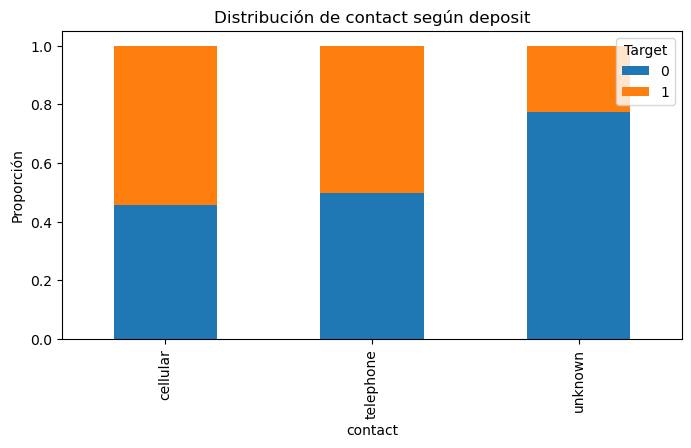

month: Chi² = 1046.77, p-valor = 0.0000, Phi = 0.3062


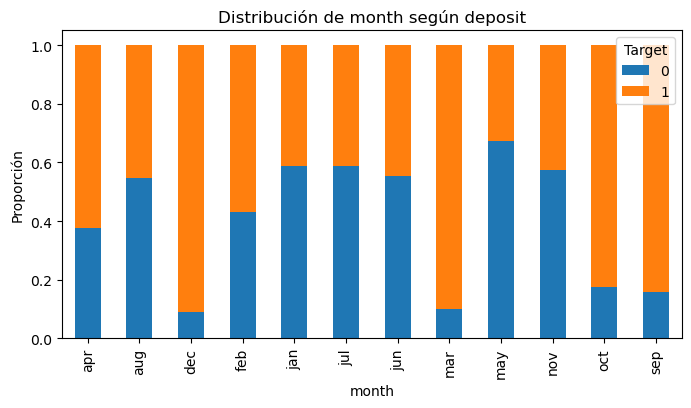

poutcome: Chi² = 1004.64, p-valor = 0.0000, Phi = 0.3000


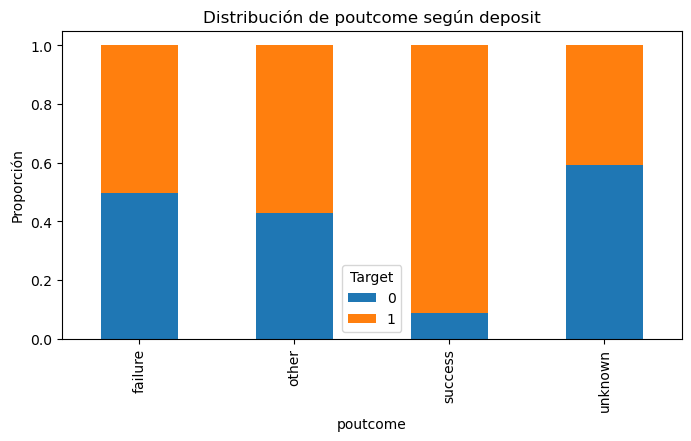

In [48]:
data['deposit'] = data['deposit'].map({'yes': 1, 'no': 0})
data['deposit'] = data['deposit'].astype(int)
target = 'deposit'
# Convertimos la variable objetivo a binaria
data[target] = data[target].astype(int)  
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

print("\nRELACIÓN ENTRE VARIABLES NUMÉRICAS Y VARIABLE OBJETIVO:")
for col in numeric_cols:
    if col != target:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=target, y=col, data=data)
        plt.title(f"Boxplot de {col} según {target}")
        plt.xlabel("Target (0=No, 1=Sí)")
        plt.ylabel(col)
        plt.show()

        # Test t de Welch
        group_yes = data[data[target] == 1][col]
        group_no = data[data[target] == 0][col]
        t_stat, p_val = ttest_ind(group_yes, group_no, equal_var=False)  

        # Convertimos la variable a numérica para evitar errores
        data[col] = pd.to_numeric(data[col], errors='coerce')  # Convierte y maneja errores

        # Correlación biserial puntual
        if data[col].dtype in ['float64', 'int64']:  # Asegurar que es numérica
            biserial_corr = pointbiserialr(data[target], data[col])[0]
        else:
            biserial_corr = np.nan  # Si la conversión falla, poner NaN
        
        print(f"{col}: t-stat = {t_stat:.2f}, p-valor = {p_val:.4f}, Correlación Biserial = {biserial_corr:.4f}")

print("\nRELACIÓN ENTRE VARIABLES CATEGÓRICAS Y LA VARIABLE OBJETIVO:")
for col in categorical_cols:
    contingency_table = pd.crosstab(data[col], data[target])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Calcular Phi
    n = contingency_table.sum().sum()
    phi_cramer = np.sqrt(chi2 / n)
    
    print(f"{col}: Chi² = {chi2:.2f}, p-valor = {p:.4f}, Phi = {phi_cramer:.4f}")
    
    # Gráfico de barras apiladas
    contingency_table.div(contingency_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title(f"Distribución de {col} según {target}")
    plt.xlabel(col)
    plt.ylabel("Proporción")
    plt.legend(title="Target")
    plt.show()

Cómo podemos evaluar la influencia de las variables
Numéricas:
- P-value: si es inferior a 0.05 la variable tiene relación significativa.
- t-stat: valores más grandes indican mayor diferencia entre deposit 'yes' / 'no'.
- correlación biserial: cuando más cercano a 1, relación más fuerte.

Categóricas:
- P-value: si es inferior a 0.05 la variable tiene relación significativa.
- Chi2: valores más grandes indican mayor diferencia entre deposit 'yes' / 'no'.
- Phi: cuando más cercano a 1, relación más fuerte.

Siguiendo estas pautas, podemos indicar que las variables con mayor relación con la variable objetivo son:
- duration
- housing
- contact
- month
- poutcome
Porque todas ellas tienen un p-value inferior a 0.05, y una correlación biserial o un Phi valor superior a 0.2.
Si quisiéramos tener más información, podríamos añadir también 'job', que tiene un valor Phi de 0.18.

Eliminamos las columnas que no son útiles...

In [61]:
# Eliminar columnas
columns_to_drop = ['age', 'job', 'marital', 'education', 'default', 'balance', 'loan', 'day', 'pdays', 'previous'] 
data_cleaned = data.drop(columns=columns_to_drop)

print("Primeras filas")
print(data_cleaned.head())

Primeras filas
  housing  contact month  duration  campaign poutcome deposit
0     yes  unknown   may      1042         1  unknown     yes
1      no  unknown   may      1467         1  unknown     yes
2     yes  unknown   may      1389         1  unknown     yes
3     yes  unknown   may       579         1  unknown     yes
4      no  unknown   may       673         2  unknown     yes


Como las variables categóricas deben codificarse generando matrices, el resultado final sería mucho más grande. Por eso, necesitamos agrupar 'month' en estaciones.

In [62]:
# Agrupar month
# Diccionario para cambiar los meses a estaciones
mes_a_estacion = {
    'Jan': 'Winter', 'Feb': 'Winter', 'Dec': 'Winter',
    'Mar': 'Spring', 'Apr': 'Spring', 'May': 'Spring',
    'Jun': 'Summer', 'Jul': 'Summer', 'Aug': 'Summer',
    'Sep': 'Autum', 'Oct': 'Autum', 'Nov': 'Autum'
}

data_cleaned['month'] = data_cleaned['month'].str.strip().str.title()
data_cleaned['month'] = data_cleaned['month'].map(mes_a_estacion)
print(data_cleaned['month'])

0        Spring
1        Spring
2        Spring
3        Spring
4        Spring
          ...  
11157    Spring
11158    Summer
11159    Summer
11160    Spring
11161    Summer
Name: month, Length: 11162, dtype: object


## División del modelo

Dividir el conjunto de datos
Utilizaremos un 80% de los datos para entrenar nuestro modelo. Se necesita una gran cantidad de datos para entrenar el modelo, ya que tiene que relacionar variables y aprender patrones. Cuanto mayor número de datos proporcionemos, mejor será el modelo (siempre y cuando no haya overfitting).

Por otro lado, utilizaremos el 20% de los datos para testear el modelo. Es fundamental no utilizar estos datos para entrenar el modelo para ver si nuestro algoritmo tiene un buen deswempeño en datos no entrenados.

Es imprescindible la estratificación de la variable objetivo para que se mantenta igual en el conunto de entrenamiento que en el de prueba. Si no, podríamos tener un conunto de datos en los que las proporcionesde clases son diferentes.

In [63]:
X = data_cleaned.drop(columns='deposit')  # Variables
y = data_cleaned['deposit']               # Objetivo

# Partición estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar las proporciones en train y test
print("Proporciones en y_train:")
print(y_train.value_counts(normalize=True))

print("Proporciones en y_test:")
print(y_test.value_counts(normalize=True))

Proporciones en y_train:
deposit
no     0.526151
yes    0.473849
Name: proportion, dtype: float64
Proporciones en y_test:
deposit
no     0.526198
yes    0.473802
Name: proportion, dtype: float64


## Codificar variables categóricas
Como no podemos utilizar variables categóricas con texto, tenemos que codificarlas. Podemos clasificar nuestras variables categóricas como:
1. Ordinales: tienen un orden narutal (una jerarquía) --> Usamos label encoding
2. Nominales: no tienen orden natural y no se interpretan como valores numéricos --> Usamos one hot encoding
3. Booleanas: son de 'sí' o 'no' --> Usamos label encoding

#### Categóricas ordinales
Para las variables categóricas ordinales, como "education", podemos asignar un número a cada categoria.
Podemos utilizar LabelEncoder. Pero como no es importante para nuestro algoritmo, no hará falta codificarla.

#### Categóricas nominales
Por otro lado, tenemos variables categóricas nominales, como el tipo de trabajo, para lo que vamos a utilizar el One-hot encoding.
Si no hubiéramos eliminado la categoría 'job', agruparíamos en función de la educación necesaria para desempeñar el trabajo:
- Alta calificación: management, self-employed, entrepreneur
- Media calificación: admin., services, blue-collar
- Baja calificación: housemaid, student, retired

In [64]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['contact', 'month', 'poutcome']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Usar sparse_output=False para obtener una matriz densa
encoder.fit(X_train[categorical_cols])

# Transformar X_train y X_test a la vez
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Asegurar que X_test tenga las columnas en el mismo orden que X_train
#X_test_encoded_df = X_test_encoded_df[X_train_encoded_df.columns]

### Categóricas booleanas

In [66]:
housing_encoded_train = X_train['housing'].map({'yes': 1, 'no': 0})
housing_encoded_test = X_test['housing'].map({'yes': 1, 'no': 0})

#### Variable objetivo

In [67]:
# Variable objetivo codificada train
deposit_encoded_train = y_train.map({'yes': 1, 'no': 0})
print(deposit_encoded_train)

# Variable objetivo codificada test
deposit_encoded_test = y_test.map({'yes': 1, 'no': 0})
print("\n", deposit_encoded_test)

8644    0
2632    1
3056    1
1080    1
4006    1
       ..
3751    1
9695    0
3579    1
3386    1
9743    0
Name: deposit, Length: 8929, dtype: int64

 8220     0
2521     1
7949     0
7879     0
616      1
        ..
11141    0
3589     1
4200     1
1959     1
903      1
Name: deposit, Length: 2233, dtype: int64


## Estandarización
Las variables numéricas pueden tener escalas muy diferentes (por ejemplo, ingresos en miles). La estandarización asegura que todas las variables numéricas tengan una escala similar, generalmente con media de 0 y desviación estándar de 1. 
Además, muchos algoritmos pueden ser sensibles a las escalas de las variables.

In [68]:
from sklearn.preprocessing import StandardScaler
# Selección
numeric_columns = ['duration']

scaler = StandardScaler() #creamos objeto
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns]) #tranformamos
print(X_train.head())

     housing   contact   month  duration  campaign poutcome
8644      no  cellular  Summer -0.343988         3  unknown
2632      no  cellular   Autum -0.317972         1  success
3056      no  cellular  Winter -0.485632         1  success
1080     yes  cellular   Autum  1.170736         3  unknown
4006      no  cellular   Autum -0.283283         2  unknown


In [69]:
numeric_columns = ['duration']
df_numeric_train = X_train[numeric_columns] 

df_bool_train = pd.concat([housing_encoded_train], axis = 1)

# Índices alineados
X_train_encoded_df = X_train_encoded_df.reset_index(drop=True)
df_numeric_train = df_numeric_train.reset_index(drop=True)
df_bool_train = df_bool_train.reset_index(drop=True)

# Combinar todos los DataFrames
df_final_train = pd.concat([X_train_encoded_df, df_numeric_train, df_bool_train], axis=1)
df_final_train.dropna(inplace=True)

# Exportar a un archivo CSV
df_final_train.to_csv("train_encoded.csv", index=False)

print("Archivo CSV creado con éxito: train_encoded.csv")
train_encoded = pd.read_csv('train_encoded.csv')
print(train_encoded.head())

Archivo CSV creado con éxito: train_encoded.csv
   contact_cellular  contact_telephone  contact_unknown  month_Autum  \
0               1.0                0.0              0.0          0.0   
1               1.0                0.0              0.0          1.0   
2               1.0                0.0              0.0          0.0   
3               1.0                0.0              0.0          1.0   
4               1.0                0.0              0.0          1.0   

   month_Spring  month_Summer  month_Winter  poutcome_failure  poutcome_other  \
0           0.0           1.0           0.0               0.0             0.0   
1           0.0           0.0           0.0               0.0             0.0   
2           0.0           0.0           1.0               0.0             0.0   
3           0.0           0.0           0.0               0.0             0.0   
4           0.0           0.0           0.0               0.0             0.0   

   poutcome_success  poutcome_un

In [57]:
'''
# Ponemos igual todos los indices
deposit_encoded_train = deposit_encoded_train.reindex(df_final_train.index)
print(df_final_train.index.equals(deposit_encoded_train.index))  # Saber si son iguales los índices'''

'\n# Ponemos igual todos los indices\ndeposit_encoded_train = deposit_encoded_train.reindex(df_final_train.index)\nprint(df_final_train.index.equals(deposit_encoded_train.index))  # Saber si son iguales los índices'

## Aplicamos a test

In [70]:
df_bool_test = pd.concat([housing_encoded_test], axis = 1)

numeric_columns = ['duration']
df_numeric_test = X_test[numeric_columns] 

# Índices están alineados
X_test_encoded_df = X_test_encoded_df.reset_index(drop=True)
df_numeric_test = df_numeric_test.reset_index(drop=True)
df_bool_test = df_bool_test.reset_index(drop=True)

# Combinar todos los DataFrames
df_final_test = pd.concat([X_test_encoded_df, df_numeric_test, df_bool_test], axis=1)

df_final_test.dropna(inplace=True)

# Estandarización
df_final_test[numeric_columns] = scaler.transform(df_final_test[numeric_columns]) #tranformamos

# Exportar a un archivo CSV
df_final_test.to_csv("test_encoded.csv", index=False)

print("Archivo CSV creado con éxito: test_encoded.csv")
test_encoded = pd.read_csv('test_encoded.csv')
print(test_encoded.head())

Archivo CSV creado con éxito: test_encoded.csv
   contact_cellular  contact_telephone  contact_unknown  month_Autum  \
0               1.0                0.0              0.0          0.0   
1               1.0                0.0              0.0          0.0   
2               1.0                0.0              0.0          1.0   
3               0.0                0.0              1.0          0.0   
4               1.0                0.0              0.0          0.0   

   month_Spring  month_Summer  month_Winter  poutcome_failure  poutcome_other  \
0           0.0           0.0           1.0               0.0             0.0   
1           0.0           1.0           0.0               0.0             0.0   
2           0.0           0.0           0.0               1.0             0.0   
3           1.0           0.0           0.0               0.0             0.0   
4           0.0           1.0           0.0               0.0             0.0   

   poutcome_success  poutcome_unk

# Entramos el modelo

In [71]:
# Librería
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [79]:
# Concatenar X con y
# OJO!! Primero reseteamos índices, super importante para no tener Nan
df_final_train = df_final_train.reset_index(drop=True)
deposit_encoded_train = deposit_encoded_train.reset_index(drop=True)
training = pd.concat([df_final_train, deposit_encoded_train], axis=1)

df_final_test = df_final_test.reset_index(drop=True)
deposit_encoded_test = deposit_encoded_test.reset_index(drop=True)
testing = pd.concat([df_final_test, deposit_encoded_test], axis=1)

In [80]:
# Especificar las columnas para características y variable objetivo
feature_columns = training.drop('deposit', axis=1)  # características
target_column = 'deposit'

# Separar características (X) y variable objetivo (y) en el conjunto de entrenamiento
X_train = training.drop('deposit', axis=1)  # características
y_train = training['deposit']

# Separar características (X) y variable objetivo (y) en el conjunto de prueba
X_test = testing.drop('deposit', axis=1)  # obj
y_test = testing['deposit']

# Crear el modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Ajustar el modelo con los datos de entrenamiento
# error aquí
rf_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del Modelo:")
print(accuracy_score(y_test, y_pred))

# Importancia de las características
feature_importances = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': rf_classifier.feature_importances_}
).sort_values(by='Importance', ascending=False)

print("\nImportancia de las características:")
print(feature_importances)

Matriz de Confusión:
[[908 267]
 [255 803]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1175
           1       0.75      0.76      0.75      1058

    accuracy                           0.77      2233
   macro avg       0.77      0.77      0.77      2233
weighted avg       0.77      0.77      0.77      2233


Precisión del Modelo:
0.7662337662337663

Importancia de las características:
              Feature  Importance
11           duration    0.766523
9    poutcome_success    0.049462
12            housing    0.043182
2     contact_unknown    0.031453
10   poutcome_unknown    0.027720
0    contact_cellular    0.019841
5        month_Summer    0.015424
4        month_Spring    0.013490
3         month_Autum    0.008865
7    poutcome_failure    0.007820
6        month_Winter    0.006527
8      poutcome_other    0.005014
1   contact_telephone    0.004679


La **matriz de confusión** es una tabla que muestra el rendimiento del modelo clasificando ejemplos positivos (clase 1) y negativos (clase 0).
- 908 (TP - Verdaderos Positivos): Casos correctamente clasificados como clase 0.
- 267 (FP - Falsos Positivos): Casos de clase 0 incorrectamente clasificados como clase 1.
- 255 (FN - Falsos Negativos): Casos de clase 1 incorrectamente clasificados como clase 0.
- 803 (TN - Verdaderos Negativos): Casos correctamente clasificados como clase 1.

Esto indica que el modelo tiene buen desempeño general para verdaderos positivos y negativos, pero todavía comete errores en ambas clases.


El **informe de clasificación** incluye métricas clave para cada clase (0 y 1).
Clase 0:
- Precision: De todos los ejemplos que el modelo predijo como clase 0, el 78% realmente eran clase 0.
- Recall: De todos los ejemplos reales de clase 0, el modelo identificó correctamente el 77%.
- F1-Score: Media armónica entre precisión y recall, que penaliza más los desequilibrios entre ellas. Es 0.78 para la clase 0.

Clase 1:
- Precision: De todos los ejemplos que el modelo predijo como clase 1, el 75% realmente eran clase 1.
- Recall: De todos los ejemplos reales de clase 1, el modelo identificó correctamente el 76%.
- F1-Score: Es 0.75, lo que refleja un balance similar entre precisión y recall para la clase 1.

Promedios:
- Accuracy: El modelo clasifica correctamente el 77% de los ejemplos totales.
- Macro avg: promedio de 77%
- Weighted avg: promedio de 77%

Precisión del modelo: El valor 0.8499776 coincide con la precisión global del modelo, que es la proporción de predicciones correctas.

Importancia de las características:
- Según el modelo de Random Forest Classificator, la variable más importante es la duración ('duration') de la campaña, que explica el 76.6% del modelo. Después de esta, las variables 'poutcome success' y 'housing' tienen un peso de un 4-5% cada una.

En conclusión, si queremos que más clientes acepten el depósito a largo término, debemos incrementar la duración. 